# Notebook 05: Linear Regression - Predicting Sales for New Models

This notebook develops a regression model and evaluates predictions for new model sales using attributes for watches in datasets cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [407]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer

In [408]:
# Import data
df_models = pd.read_csv('../cleaned_datasets/models.csv')
df_new_models = pd.read_csv('../cleaned_datasets/new_models.csv')

### Train-test split

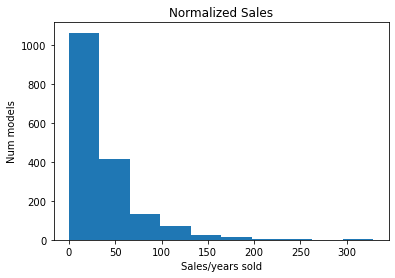

In [409]:
# Calculate a target value - Normalized Sales, which is the overall sales divided by the number of years that the model was sold
df_models['overall_sales'] = (df_models['2015'] + 
                            df_models['2016'] + 
                            df_models['2017'] + 
                            df_models['2018'] + 
                            df_models['2019'] + 
                            df_models['2020'] + 
                            df_models['2021'] + 
                            df_models['total_sales_2022'])

norm_sales = []
for i in df_models.index:
    years_of_sales = sum([1 for sales in df_models.loc[i,['2015', '2016', '2017', '2018', '2019', '2020', '2021']] if sales > 0])
    if df_models.loc[i,'total_sales_2022'] > 0:
        years_of_sales += 4/12
    if years_of_sales == 0:
        norm_sales.append(0)
    else:
        norm_sales.append(df_models.loc[i,'overall_sales']/years_of_sales)
df_models['norm_sales'] = norm_sales

plt.title('Normalized Sales')
plt.hist(norm_sales)
plt.xlabel('Sales/years sold')
plt.ylabel('Num models');

In [410]:
attributes = ['retail_price', 'collection', 'color', 'band_color',
       'gender', 'case_size', 'band_material']

X = df_models[attributes]

y = df_models['norm_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [411]:
X_train.columns

Index(['retail_price', 'collection', 'color', 'band_color', 'gender',
       'case_size', 'band_material'],
      dtype='object')

In [412]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1293 entries, 453 to 1126
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   retail_price   1293 non-null   float64
 1   collection     1293 non-null   object 
 2   color          1293 non-null   object 
 3   band_color     1293 non-null   object 
 4   gender         1293 non-null   object 
 5   case_size      1293 non-null   object 
 6   band_material  1293 non-null   object 
dtypes: float64(1), object(6)
memory usage: 80.8+ KB


## Baseline Model

In [413]:
baseline = np.full_like(y_test, y_train.mean())

In [414]:
rmse_baseline = mean_squared_error(y_test,baseline,squared=False)
rmse_baseline

30.549539363532595

In [415]:
residuals_baseline = y_test - baseline

In [416]:
r2_baseline = r2_score(y_test,baseline)
r2_baseline

-0.005632179565686846

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


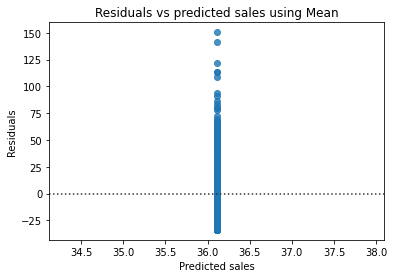

In [417]:
sns.residplot(x = baseline,
              y = residuals_baseline,
              lowess = True,
              line_kws = {'color':'red'})
plt.title('Residuals vs predicted sales using Mean')
plt.xlabel('Predicted sales')
plt.ylabel('Residuals');

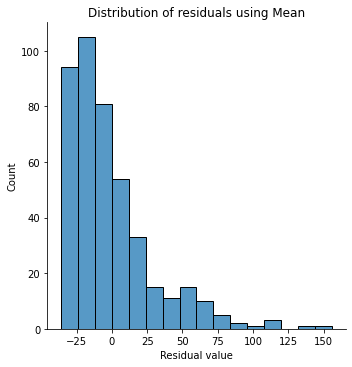

In [418]:
# Create residuals histogram to check for normal distribution of errors
sns.displot(residuals_baseline, binwidth =12)
plt.title('Distribution of residuals using Mean')
plt.xlabel('Residual value');

Definitely not normally distributed. There is a tail for the higher sales models.

## Exploring different models

In [419]:
pipe_lr = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    ('lr',LinearRegression())
])

In [420]:
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_train,y_train), pipe_lr.score(X_test,y_test)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(0.44097228796332644, -1.4590193688079501e+23)

In [421]:
preds_lr = pipe_lr.predict(X_test)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [422]:
preds_lr_zero = [x if x > 0 else 0 for x in preds_lr]
preds_lr_zero = [x if x < 1000 else 0 for x in preds_lr_zero]

In [423]:
residuals_lr = y_test - preds_lr_zero

In [424]:
mean_squared_error(y_test, preds_lr_zero)

859.7478183633654

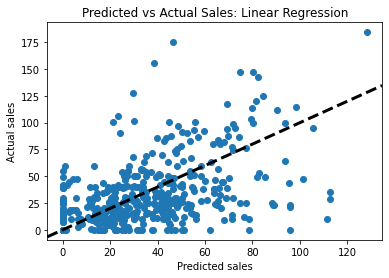

In [425]:
plt.scatter(preds_lr_zero,y_test)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.xlabel('Predicted sales')
plt.ylabel('Actual sales')
plt.title('Predicted vs Actual Sales: Linear Regression');

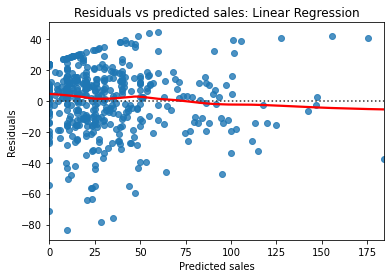

In [426]:
sns.residplot(x = y_test,
              y = residuals_lr,
              lowess = True,
              line_kws = {'color':'red'})
plt.title('Residuals vs predicted sales: Linear Regression')
plt.xlabel('Predicted sales')
plt.ylabel('Residuals');

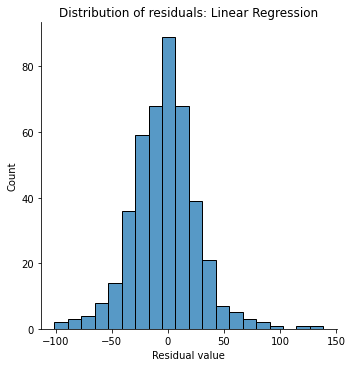

In [427]:
# Create residuals histogram to check for normal distribution of errors
sns.displot(residuals_lr, binwidth =12)
plt.title('Distribution of residuals: Linear Regression')
plt.xlabel('Residual value');

Errors appear to be normally distributed.

In [428]:
def create_evaluate_model(model, X, y):
    print(model[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                         attributes[1::])],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
    
    pipe = Pipeline([
        ('ct',ct),
        ('ss',StandardScaler()),
        model
    ])

    pipe.fit(X_train,y_train)
    print('Train score:', pipe.score(X_train,y_train))
    print('Test raw score:', pipe_lr.score(X_test,y_test))

    preds = pipe.predict(X_test)

    preds = [x if x > 0 else 0 for x in preds]
    preds = [x if x < 1000 else 0 for x in preds]

    test_cleaned_rmse = mean_squared_error(y_test, preds,squared=False)

    print('Test cleaned score:', r2_score(y_test, preds))
    print('Test cleaned RMSE:',test_cleaned_rmse)
    print('Baseline RMSE:', mean_squared_error(y_test,np.full_like(y_test, y_train.mean()),squared=False))
    
    residuals = y_test - preds
    plt1 = plt.figure()
    plt.scatter(preds,y_test)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.xlabel('Predicted sales')
    plt.ylabel('Actual sales')
    plt.title(f'Predicted vs Actual Sales: {model[1]}');

    plt2 = plt.figure()
    plt2.suptitle(f'Residuals vs predicted sales: {model[1]}')
    sns.residplot(x = y_test,
                  y = residuals,
                  lowess = True,
                  line_kws = {'color':'red'})
    plt.xlabel('Predicted sales')
    plt.ylabel('Residuals');
    
    print()
    return preds, test_cleaned_rmse

In [429]:
def plot_preds(y_test, preds, model_name):
    """ This function creates two plots: the predictions against the actual values, and the predictions against the residuals.
    
    Args:
        y_test (Pandas series): actual values
        preds (Pandas series): predictions
    """    
    residuals = y_test - preds
    plt1 = plt.figure()
    plt.scatter(preds,y_test)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.xlabel('Predicted sales')
    plt.ylabel('Actual sales')
    plt.title(f'Predicted vs Actual Sales: {model_name}');

    plt2 = plt.figure()
    plt2.suptitle(f'Residuals vs predicted sales: {model_name}')
    sns.residplot(x = y_test,
                  y = residuals,
                  lowess = True,
                  line_kws = {'color':'red'})
    plt.xlabel('Predicted sales')
    plt.ylabel('Residuals');
    

In [430]:
def create_evaluate_model(model, X, y):
    print(model[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    pipe = Pipeline([
        ('ct',ct),
        ('ss',StandardScaler()),
        model
    ])

    pipe.fit(X_train,y_train)
    print('Train score:', pipe.score(X_train,y_train))
    print('Test raw score:', pipe_lr.score(X_test,y_test))

    preds = pipe.predict(X_test)

    preds = [x if x > 0 else 0 for x in preds]
    preds = [x if x < 1000 else 0 for x in preds]

    test_cleaned_rmse = mean_squared_error(y_test, preds,squared=False)

    print('Test cleaned score:', r2_score(y_test, preds))
    print('Test cleaned RMSE:',test_cleaned_rmse)
    print('Baseline RMSE:', mean_squared_error(y_test,np.full_like(y_test, y_train.mean()),squared=False))
    
    plot_preds(y_test, preds, model[0])
    
    print()
    return preds, test_cleaned_rmse

In [431]:
models = [('lr',LinearRegression()), ('ridge',RidgeCV(alphas=np.logspace(0,5,100))),
          ('lasso',LassoCV(alphas=np.arange(0.001,10,1))),('knn',KNeighborsRegressor(n_neighbors=3)),
          ('rf', RandomForestRegressor(n_estimators=500)), ('ab', AdaBoostRegressor(base_estimator=RandomForestRegressor())),
          ('et', ExtraTreesRegressor(n_estimators=200))]

LinearRegression()
Train score: 0.44097228796332644
Test raw score: -1.4590193688079501e+23
Test cleaned score: 0.07359495358959645
Test cleaned RMSE: 29.321456620764348
Baseline RMSE: 30.549539363532595

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/896753859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds[f'preds_{model[0]}'] = preds
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value

Train score: 0.4123790239744848
Test raw score: -1.4590193688079501e+23
Test cleaned score: 0.14354340063745352
Test cleaned RMSE: 28.192771097525043
Baseline RMSE: 30.549539363532595

LassoCV(alphas=array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]))


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/896753859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds[f'preds_{model[0]}'] = preds
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarnin

Train score: 0.315835637511899
Test raw score: -1.4590193688079501e+23
Test cleaned score: 0.14100847979909603
Test cleaned RMSE: 28.23446243362045
Baseline RMSE: 30.549539363532595

KNeighborsRegressor(n_neighbors=3)
Train score: 0.560740439319311
Test raw score: -1.4590193688079501e+23
Test cleaned score: -0.157834541617222
Test cleaned RMSE: 32.77995371553779
Baseline RMSE: 30.549539363532595

RandomForestRegressor(n_estimators=500)


/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/896753859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds[f'preds_{model[0]}'] = preds


Train score: 0.8554432993074947
Test raw score: -1.4590193688079501e+23
Test cleaned score: 0.1810091876909562
Test cleaned RMSE: 27.569227681152004
Baseline RMSE: 30.549539363532595

AdaBoostRegressor(base_estimator=RandomForestRegressor())


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/896753859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds[f'preds_{model[0]}'] = preds


Train score: 0.8644976293353799
Test raw score: -1.4590193688079501e+23
Test cleaned score: 0.11646226109897129
Test cleaned RMSE: 28.6350296662644
Baseline RMSE: 30.549539363532595



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/896753859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds[f'preds_{model[0]}'] = preds


ExtraTreesRegressor(n_estimators=200)
Train score: 0.9417589177656344
Test raw score: -1.4590193688079501e+23
Test cleaned score: -0.41805257357716075
Test cleaned RMSE: 36.2769905069607
Baseline RMSE: 30.549539363532595

Best RMSE: 27.569227681152004
Best model: rf


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/896753859.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds[f'preds_{model[0]}'] = preds


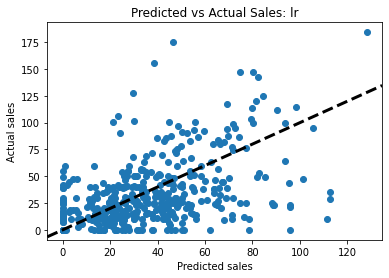

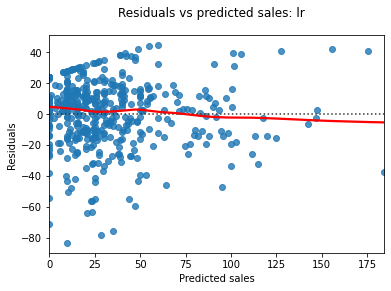

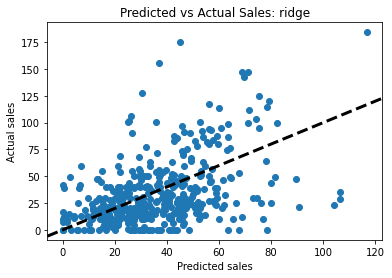

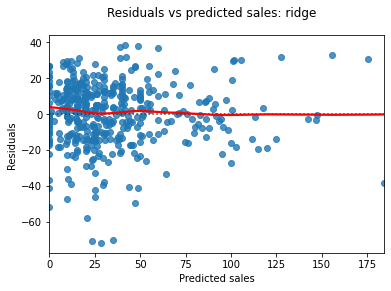

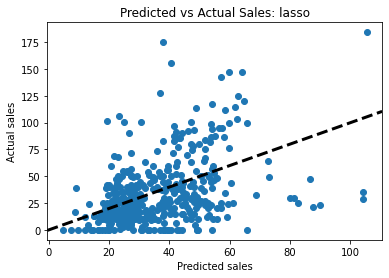

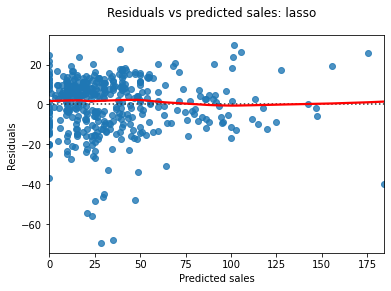

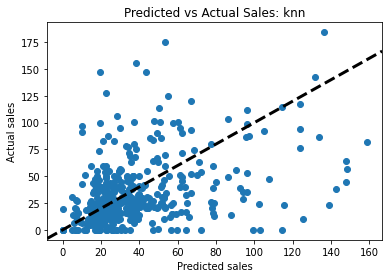

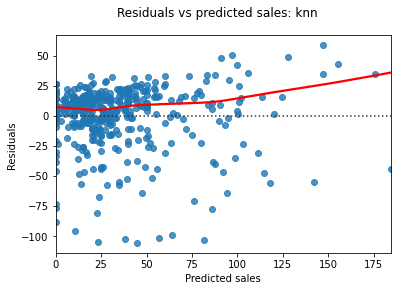

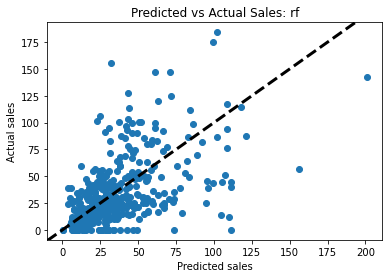

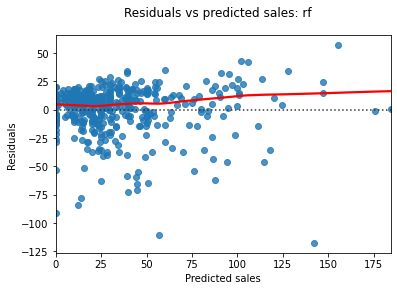

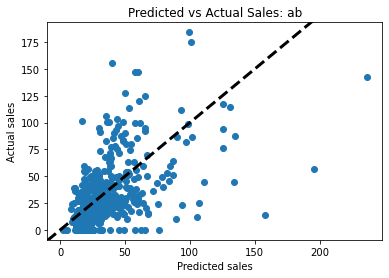

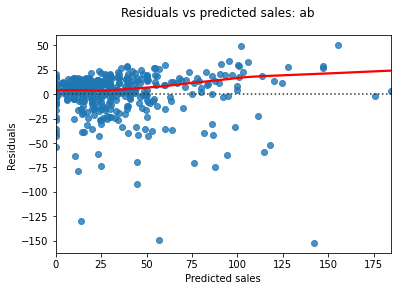

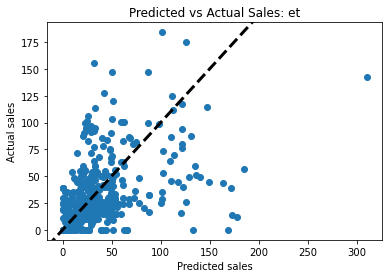

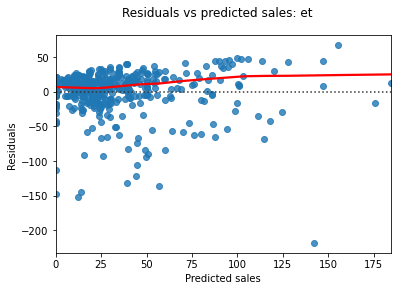

In [432]:
best_rmse = 1000000
dcolumnsreds = X_test.copy()
df_preds['y_test'] = y_test
df_preds = df_preds[['y_test']]
for model in models:
    preds, rmse = create_evaluate_model(model, X, y)
    df_preds[f'preds_{model[0]}'] = preds
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model[0]
        
print('Best RMSE:', best_rmse)
print('Best model:', best_model)

In [433]:
df_preds_avg = df_preds[['preds_ridge','preds_rf']]
df_preds['avg'] = 0
for pred in df_preds_avg:
    df_preds['avg'] = df_preds['avg'] + df_preds_avg[pred]
df_preds['avg'] = df_preds['avg']/len(df_preds_avg.columns)

In [434]:
df_preds

,y_test,preds_lr,preds_ridge,preds_lasso,preds_knn,preds_rf,preds_ab,preds_et,avg
300,26.000000,19.674548,28.843295,30.104291,28.500000,29.789401,32.506583,30.000000,29.316348
1075,32.812500,41.895251,38.668520,27.895183,64.500000,62.834724,61.094893,88.312500,50.751622
535,40.000000,32.369860,33.357691,36.014032,22.233333,30.988747,33.791806,28.309048,32.173219
1318,0.000000,14.725329,16.808062,16.404712,6.333333,7.307538,15.077357,0.000000,12.057800
561,33.333333,51.350329,46.158826,45.574074,40.022222,49.337467,53.470833,53.176333,47.748146
...,...,...,...,...,...,...,...,...,...
1713,24.000000,0.000000,11.353115,13.483278,18.750000,3.899371,8.939508,0.000000,7.626243
818,45.000000,34.061267,36.881425,39.583284,30.250000,26.010522,28.125238,23.264500,31.445973
1110,0.000000,16.190173,30.567020,33.099361,32.333333,30.194294,25.633571,41.316250,30.380657
1420,0.000000,31.416735,34.485267,43.244329,19.250000,29.070549,31.280508,26.945179,31.777908


In [435]:
mean_squared_error(y_test,df_preds['avg'],squared=False)

26.093946866964444

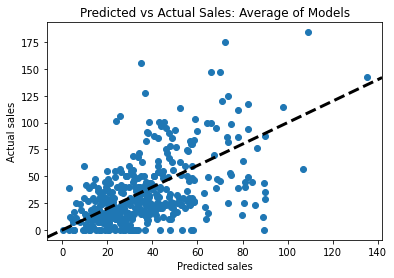

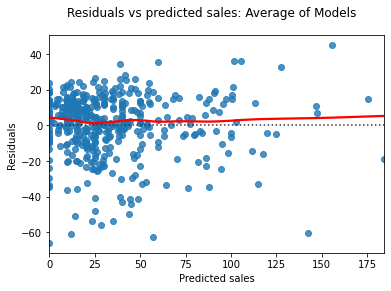

In [436]:
plot_preds(y_test,df_preds['avg'],'Average of Models')

## Production model

In [443]:
# Create new data frame with attributes from model to make predictions for new models in proposal
test = df_new_models[attributes]

# Impute missing retail prices
knn_imp = KNNImputer()
test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])

# Fix small casting issue
test['case_size'] = test['case_size'].astype(str)

# Setup pipeline for preprocessing and modeling
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                         attributes[1::])],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
pipe = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    ('rf',RandomForestRegressor(n_estimators=500))
])

# Fit model with train set
pipe.fit(X_train,y_train)

# Generate predictions for new models
preds = pipe.predict(test)

# Save new model predictions (monthly order) to csv
new_model_predictions = df_new_models[['style_id']]
new_model_predictions['monthly_predictions_Q3'] = preds/12
new_model_predictions.to_csv('../cleaned_datasets/new_models_predictions.csv',index=False)

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/59514533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_6432/59514533.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['case_size'] = test['case_size'].astype(str)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0